In [ ]:
from google.colab import files

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd

## 1️ Carga y exploración inicial de los datos

**Objetivo:** importar el conjunto de datos original `transcripts_FED.csv` que contiene transcripciones de reuniones de la Reserva Federal (FED) con variables textuales y económicas.

**Descripción de columnas:**
- `date`: fecha de la reunión.
- `text`: transcripción completa.
- `tokens`: lista de palabras tokenizadas.
- `Tipos de interés`: tasa de interés base.
- `Cambio tasa de interés`: variación con respecto al periodo anterior.

**Acciones realizadas:**
- Montaje de Google Drive en Colab para acceder al archivo CSV.
- Lectura del dataset con `pandas.read_csv()`.
- Visualización de las primeras filas con `df.head()` para verificar formato y tipos de datos.

**Justificación (CRISP-ML – Data Understanding):**
Esta etapa permite comprender la estructura del dataset y verificar su calidad inicial. Es fundamental antes de aplicar cualquier transformación o modelo de aprendizaje automático.

In [ ]:
df= pd.read_csv("/content/drive/MyDrive/Proyecto Integrador/transcripts_FED.csv", header=0)
df.head()

date                                               text  \
0  1991-03-26  This is the first time in a long time that [th...   
1  1991-05-14  Are there any comments raised by the report on...   
2  1991-07-03  [Statement--see Appendix.] Questions for Sam? ...   
3  1991-08-20  Good morning, everyone. Would somebody like to...   
4  1991-10-01  Good morning, everyone. We have Tom Hoenig wit...   

                                              tokens  Tipos de interés  \
0  ['first', 'time', 'long', 'time', 'committee',...              5.75   
1  ['comments', 'raised', 'report', 'examination'...              5.50   
2  ['statement', 'see', 'appendix', 'questions', ...              5.50   
3  ['good', 'morning', 'everyone', 'would', 'some...              5.25   
4  ['good', 'morning', 'everyone', 'tom', 'hoenig...              5.00   

   Cambio tasa de interés  
0                     NaN  
1                   -0.25  
2                    0.00  
3                   -0.25  
4                   -0.25

## 2️ Lemmatización del texto

**Objetivo:** normalizar las palabras para reducir variabilidad lingüística y mantener solo la raíz semántica (por ejemplo, *running → run*).

**Herramientas utilizadas:**
- `nltk.WordNetLemmatizer` para obtener la forma base de cada palabra.
- `pos_tag()` para identificar la categoría gramatical (sustantivo, verbo, adjetivo, adverbio).
- Mapeo de etiquetas POS a los tipos de WordNet mediante la función `get_wordnet_pos()`.

**Proceso aplicado:**
1. Tokenización de los textos (`word_tokenize`).
2. Asignación de etiquetas POS.
3. Lematización de cada palabra según su tipo gramatical.
4. Creación de una nueva columna `lemmatized_tokens`.

**Resultado:** una versión del texto más limpia y homogénea que facilita el análisis posterior y mejora la calidad de las características generadas (TF-IDF, n-gramas).

**Justificación (CRISP-ML – Data Preparation):**
La lematización reduce ruido textual y dimensionalidad, permitiendo que el modelo aprenda patrones más robustos entre documentos.

In [ ]:
 pip install nltk

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
#aplicar POS
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
#Función de lemmatización
def lemmatize_text(text):
    if not isinstance(text, str):
        return text # Return non-string values as is
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmas)

In [ ]:
df['lemmatized_tokens'] = df['tokens'].apply(lemmatize_text)

In [ ]:
df.head(1)

date                                               text  \
0  1991-03-26  This is the first time in a long time that [th...   

                                              tokens  Tipos de interés  \
0  ['first', 'time', 'long', 'time', 'committee',...              5.75   

   Cambio tasa de interés  text_length  num_tokens  avg_token_length  \
0                     NaN       135658       11115          12.20385   

                                   lemmatized_tokens  
0  [ 'first ' , 'time ' , 'long ' , 'time ' , 'co...

## 3 Reconocimiento de Entidades Nombradas (NER)

**Objetivo:** identificar nombres propios dentro de los textos, tales como personas, organizaciones o ubicaciones, para enriquecer el análisis semántico.

**Herramientas utilizadas:**
- Biblioteca `spaCy` con modelo `en_core_web_sm`.

**Proceso aplicado:**
1. Carga del modelo lingüístico de spaCy.
2. Definición de una función `extract_entities(text)` para extraer entidades.
3. Creación de una nueva columna `entities` con tuplas (`entidad`, `etiqueta`).

**Ejemplos de etiquetas:**
- `ORG`: organización (ej. *Federal Reserve*).
- `PERSON`: persona (ej. *Jerome Powell*).
- `GPE`: país o ubicación (ej. *United States*).

**Justificación:**
El NER aporta información contextual valiosa sobre actores y entidades mencionadas, lo cual puede relacionarse con cambios en las tasas de interés o el tono del discurso.

In [ ]:
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Función para obtener entidades
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

In [ ]:
df['entities'] = df['text'].apply(extract_entities)

In [21]:
df.head(1)

date                                               text  \
0  1991-03-26  This is the first time in a long time that [th...   

                                              tokens  Tipos de interés  \
0  ['first', 'time', 'long', 'time', 'committee',...              5.75   

   Cambio tasa de interés  text_length  num_tokens  avg_token_length  \
0                     NaN       135658       11115          12.20385   

                                   lemmatized_tokens  \
0  [ 'first ' , 'time ' , 'long ' , 'time ' , 'co...   

                                            entities  
0  [(first, ORDINAL), (Committee, ORG), (Don Kohn...

##  Representación vectorial del texto (TF-IDF y N-gramas)

**Objetivo:** convertir los textos procesados en representaciones numéricas útiles para modelos de machine learning.

**Técnica empleada:**
- **TF-IDF (Term Frequency – Inverse Document Frequency):** pondera la relevancia de cada término en función de su frecuencia dentro del documento y en el corpus.
- Se aplicaron **n-gramas** de tamaño 1 a 3 (`ngram_range=(1,3)`) para capturar combinaciones de palabras frecuentes.

**Parámetros utilizados:**
- `min_df=5`: descarta términos demasiado raros.
- `max_df=0.8`: elimina términos excesivamente comunes.
- `ngram_range=(1,3)`: genera unigramas, bigramas y trigramas.

**Resultado:**
- Matriz dispersa con ~224,227 columnas (una por término o secuencia).
- Nueva estructura `tokens_ngrams_text` que asocia cada documento con sus ponderaciones TF-IDF.

**Justificación (CRISP-ML – Feature Engineering):**
La representación TF-IDF permite medir la importancia relativa de las palabras y frases dentro del discurso, habilitando la posterior selección o extracción de características más relevantes.


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
vectorizer = TfidfVectorizer(ngram_range=(1,3),  # unigramas, bigramas y trigramas
                             min_df=5,           # descarta n-gramas raros
                             max_df=0.8)         # descarta demasiado comunes
tokens_ngrams = vectorizer.fit_transform(df["lemmatized_tokens"])

In [24]:
print(tokens_ngrams)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3213989 stored elements and shape (230, 224227)>
  Coords	Values
  (0, 114296)	0.008483422769108632
  (0, 3026)	0.0078245466885088
  (0, 114724)	0.005592195406564248
  (0, 9465)	0.003648000466376174
  (0, 94815)	0.010503911437879468
  (0, 194886)	0.017961087339167785
  (0, 191203)	0.0069709954154095295
  (0, 12204)	0.010403194417688276
  (0, 126141)	0.008412154423559108
  (0, 48412)	0.006556043915264083
  (0, 161646)	0.01146360503084143
  (0, 195623)	0.014592001865504696
  (0, 145015)	0.004915259791392437
  (0, 18981)	0.012447351274890443
  (0, 123969)	0.0200186721308671
  (0, 133542)	0.03576908028103339
  (0, 70515)	0.008185174698064367
  (0, 1130)	0.0035332037008799404
  (0, 194832)	0.011736820032763199
  (0, 65193)	0.018411321129411025
  (0, 44601)	0.009314084380252434
  (0, 153679)	0.00786174413743931
  (0, 23786)	0.004467287334471108
  (0, 84817)	0.0200186721308671
  (0, 79469)	0.0034854977077047647
  :	:
  (229, 25049)

In [25]:
vectorizer.get_feature_names_out()[:20]

array(['aa', 'aaa', 'aaa rated', 'aaa rated tranches', 'aaa tranches',
       'aaronson', 'aback', 'abandon', 'abandoned', 'abandoning', 'abate',
       'abate quickly', 'abate time', 'abated', 'abated somewhat',
       'abatement', 'abates', 'abating', 'abbreviate', 'abbreviated'],
      dtype=object)

In [26]:
tokens_ngrams_text = pd.DataFrame(tokens_ngrams.toarray(), columns=vectorizer.get_feature_names_out())
tokens_ngrams_text.head()

aa  aaa  aaa rated  aaa rated tranches  aaa tranches  aaronson  aback  \
0  0.0  0.0        0.0                 0.0           0.0       0.0    0.0   
1  0.0  0.0        0.0                 0.0           0.0       0.0    0.0   
2  0.0  0.0        0.0                 0.0           0.0       0.0    0.0   
3  0.0  0.0        0.0                 0.0           0.0       0.0    0.0   
4  0.0  0.0        0.0                 0.0           0.0       0.0    0.0   

    abandon  abandoned  abandoning  ...  zinc  zip  zombie  zone  \
0  0.000000        0.0    0.000000  ...   0.0  0.0     0.0   0.0   
1  0.000000        0.0    0.000000  ...   0.0  0.0     0.0   0.0   
2  0.005923        0.0    0.008973  ...   0.0  0.0     0.0   0.0   
3  0.000000        0.0    0.000000  ...   0.0  0.0     0.0   0.0   
4  0.008881        0.0    0.000000  ...   0.0  0.0     0.0   0.0   

   zone inflation  zone percent  zone price  zone problems  zone think  \
0             0.0           0.0         0.0            0.0         0.0   
1             0.0           0.0         0.0            0.0         0.0   
2             0.0           0.0         0.0            0.0         0.0   
3             0.0           0.0         0.0            0.0         0.0   
4             0.0           0.0         0.0            0.0         0.0   

      zones  
0  0.020019  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.000000  

[5 rows x 224227 columns]

## ✅ Conclusión de la primera parte (Preprocesamiento y vectorización)

Hasta este punto se completaron las etapas de:
1. **Carga y comprensión de datos** (fase de *Data Understanding*).
2. **Lematización y normalización textual.**
3. **Reconocimiento de entidades semánticas.**
4. **Conversión numérica de los textos con TF-IDF y n-gramas.**

Con estas transformaciones, el corpus textual se encuentra estructurado y cuantificable, listo para aplicar **ingeniería de características avanzada** (nuevas variables, codificación, escalamiento y selección) según las fases siguientes del proyecto.


## 4) Generación de nuevas características (Feature Engineering)

**Objetivo.** Enriquecer el dataset con señales textuales y temporales que puedan explicar la variación de la tasa y su cambio.  
**Qué agregamos:**
- Complejidad del texto: longitud, #tokens, longitud promedio.
- Señales de entidades (si existen): conteos por tipo (ORG, PERSON, GPE).
- Señales temporales desde `date`: año, mes, trimestre, día de la semana.


In [27]:
import pandas as pd
import numpy as np
import ast

# --- util para contar tokens seguros (lista serializada como string) ---
def safe_len_list(x):
    if isinstance(x, list):
        return len(x)
    if isinstance(x, str):
        try:
            obj = ast.literal_eval(x)
            return len(obj) if isinstance(obj, list) else 0
        except Exception:
            return 0
    return 0

# Texto básico
df['text_length'] = df['text'].astype(str).str.len()
df['num_tokens']  = df['tokens'].apply(safe_len_list)
df['avg_token_length'] = (df['text_length'] / (df['num_tokens'] + 1)).astype(float)

# Señales de entidades (si ya creaste df['entities'] como lista de (texto, label))
def count_ent(ents, label):
    if isinstance(ents, list):
        return sum(1 for _, lab in ents if lab == label)
    return 0

for lab in ['ORG', 'PERSON', 'GPE']:
    df[f'ent_{lab.lower()}'] = df['entities'].apply(lambda e: count_ent(e, lab) if isinstance(e, list) else 0)

# Fecha → componentes temporales
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['dow'] = df['date'].dt.dayofweek  # 0=lunes ... 6=domingo

df[['text_length','num_tokens','avg_token_length','ent_org','ent_person','ent_gpe','year','month','quarter','dow']].head()


text_length  num_tokens  avg_token_length  ent_org  ent_person  ent_gpe  \
0       135658       11115         12.203850      134         197       72   
1        82695        6821         12.121812       33          98       28   
2       157471       12690         12.408084       95         265       63   
3       127644       10417         12.252256       85         232       49   
4        94743        7789         12.162131       69         135       43   

   year  month  quarter  dow  
0  1991      3        1    1  
1  1991      5        2    1  
2  1991      7        3    2  
3  1991      8        3    1  
4  1991     10        4    1

## 5) Discretización / Binning y Codificación

**Objetivo.** Facilitar ciertos métodos de selección (p.ej., chi²) y permitir modelos que aprovechan categorías.  
**Qué hacemos:**
- Creamos una **clase binaria/ternaria** para el *Cambio tasa de interés*.
- Discretizamos `Tipos de interés` por cuantiles.
- Codificamos variables temporales (`month`, `dow`) con **One-Hot**.

In [28]:
from sklearn.preprocessing import OneHotEncoder

# Target binario/ternario a partir del cambio de tasa
# y_bin: {-1, 0, 1} ↓ sube = 1, igual = 0, baja = -1
df['rate_dir'] = np.select(
    [df['Cambio tasa de interés'] > 0, df['Cambio tasa de interés'] < 0],
    [1, -1],
    default=0
).astype(int)

# También una versión binaria (útil para chi² y f_classif)
df['rate_positive'] = (df['Cambio tasa de interés'] > 0).astype(int)

# Binning por cuantiles de Tipos de interés (4 contenedores)
df['interest_bin_q'] = pd.qcut(df['Tipos de interés'], q=4, duplicates='drop')

# One-Hot para mes y día de la semana
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
tmp = df[['month','dow']].fillna(-1)
month_dow_ohe = ohe.fit_transform(tmp)
ohe_cols = [f'month_{int(c.split("_")[1])}' if 'month' in c else f'dow_{int(c.split("_")[1])}'
            for c in ohe.get_feature_names_out(['month','dow'])]
month_dow_ohe = pd.DataFrame(month_dow_ohe, columns=ohe_cols, index=df.index)

# Guardamos un DF numérico consolidado para análisis posterior
num_blocks = [
    df[['Tipos de interés','Cambio tasa de interés','text_length','num_tokens','avg_token_length',
        'ent_org','ent_person','ent_gpe']].fillna(0),
    month_dow_ohe
]
num_features_df = pd.concat(num_blocks, axis=1)
num_features_df.head()

Tipos de interés  Cambio tasa de interés  text_length  num_tokens  \
0              5.75                    0.00       135658       11115   
1              5.50                   -0.25        82695        6821   
2              5.50                    0.00       157471       12690   
3              5.25                   -0.25       127644       10417   
4              5.00                   -0.25        94743        7789   

   avg_token_length  ent_org  ent_person  ent_gpe  month_1  month_2  ...  \
0         12.203850      134         197       72      0.0      0.0  ...   
1         12.121812       33          98       28      0.0      0.0  ...   
2         12.408084       95         265       63      0.0      0.0  ...   
3         12.252256       85         232       49      0.0      0.0  ...   
4         12.162131       69         135       43      0.0      0.0  ...   

   month_7  month_8  month_9  month_10  month_11  month_12  dow_1  dow_2  \
0      0.0      0.0      0.0       0.0       0.0       0.0    1.0    0.0   
1      0.0      0.0      0.0       0.0       0.0       0.0    1.0    0.0   
2      1.0      0.0      0.0       0.0       0.0       0.0    0.0    1.0   
3      0.0      1.0      0.0       0.0       0.0       0.0    1.0    0.0   
4      0.0      0.0      0.0       1.0       0.0       0.0    1.0    0.0   

   dow_3  dow_4  
0    0.0    0.0  
1    0.0    0.0  
2    0.0    0.0  
3    0.0    0.0  
4    0.0    0.0  

[5 rows x 24 columns]

## 6) Escalamiento (Normalización / Estandarización)

**Justificación.** Variables en escalas distintas sesgan métodos basados en distancia o varianza.  
Aplicamos **StandardScaler** para centrar y escalar las variables numéricas.

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_scaled = scaler.fit_transform(num_features_df)
num_scaled = pd.DataFrame(num_scaled, columns=num_features_df.columns, index=num_features_df.index)

num_scaled.describe().round(3).head()


Tipos de interés  Cambio tasa de interés  text_length  num_tokens  \
count           230.000                 230.000      230.000     230.000   
mean             -0.000                  -0.000       -0.000      -0.000   
std               1.002                   1.002        1.002       1.002   
min              -1.273                  -5.110       -1.731      -1.727   
25%              -1.036                   0.077       -0.821      -0.809   

       avg_token_length  ent_org  ent_person  ent_gpe  month_1  month_2  ...  \
count           230.000  230.000     230.000  230.000  230.000  230.000  ...   
mean             -0.000   -0.000       0.000    0.000   -0.000    0.000  ...   
std               1.002    1.002       1.002    1.002    1.002    1.002  ...   
min              -2.143   -1.386      -1.547   -1.826   -0.291   -0.213  ...   
25%              -0.680   -0.824      -0.865   -0.763   -0.291   -0.213  ...   

       month_7  month_8  month_9  month_10  month_11  month_12    dow_1  \
count  230.000  230.000  230.000   230.000   230.000   230.000  230.000   
mean     0.000    0.000   -0.000     0.000     0.000    -0.000   -0.000   
std      1.002    1.002    1.002     1.002     1.002     1.002    1.002   
min     -0.255   -0.333   -0.341    -0.255    -0.309    -0.372   -0.901   
25%     -0.255   -0.333   -0.341    -0.255    -0.309    -0.372   -0.901   

         dow_2    dow_3    dow_4  
count  230.000  230.000  230.000  
mean     0.000   -0.000   -0.000  
std      1.002    1.002    1.002  
min     -1.035   -0.177   -0.066  
25%     -1.035   -0.177   -0.066  

[5 rows x 24 columns]

## 7) Selección de características (filtro) y Extracción

Incluimos varios enfoques complementarios:

- **Umbral de varianza:** elimina features casi constantes.
- **Correlación:** identifica multicolinealidad entre numéricas.
- **Chi-cuadrado (χ²):** relación entre términos TF-IDF y `rate_positive`.
- **ANOVA (f_classif):** relación entre numéricas y el objetivo.
- **Extracción por TruncatedSVD (LSA):** reducción de dimensionalidad en TF-IDF **sparse** (más adecuado que PCA).

In [30]:
from sklearn.feature_selection import VarianceThreshold

# Usamos la matriz TF-IDF original (sparse). threshold pequeño para eliminar términos muy raros.
var_thresh = VarianceThreshold(threshold=1e-5)
tokens_var = var_thresh.fit_transform(tokens_ngrams)  # mantiene sparse
tokens_var.shape

(230, 8007)

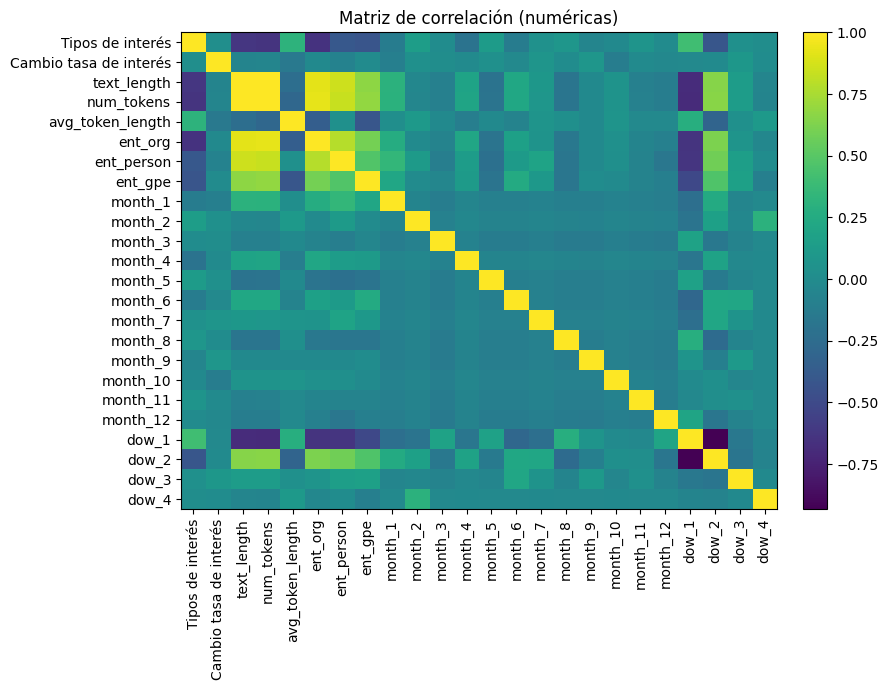

In [31]:
import matplotlib.pyplot as plt

corr = num_features_df.corr(numeric_only=True)
plt.figure(figsize=(9,7))
plt.title('Matriz de correlación (numéricas)')
im = plt.imshow(corr, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()


In [32]:
from sklearn.feature_selection import SelectKBest, chi2

# chi² requiere no-negativos → TF-IDF cumple
y_bin = df['rate_positive'].fillna(0).astype(int).values

# Selecciona las k palabras más asociadas a subidas de tasa
k = 30  # ajusta si quieres más/menos
chi2_sel = SelectKBest(score_func=chi2, k=k)
chi2_sel.fit(tokens_ngrams, y_bin)

# Top términos
feature_names = vectorizer.get_feature_names_out()
mask = chi2_sel.get_support()
top_terms = feature_names[mask]
top_scores = chi2_sel.scores_[mask]
top_sorted = sorted(zip(top_terms, top_scores), key=lambda x: x[1], reverse=True)
top_sorted[:15]

[('katrina', np.float64(4.068602638933918)),
 ('measured pace', np.float64(3.222070928656003)),
 ('public release', np.float64(2.861310331014479)),
 ('hurricane', np.float64(1.583084311166638)),
 ('measured pace language', np.float64(1.4053229802867984)),
 ('pace language', np.float64(1.3903286023997607)),
 ('delphi', np.float64(1.2349373109336166)),
 ('orange county', np.float64(0.9629717653644305)),
 ('hurricane katrina', np.float64(0.9622294059230037)),
 ('authorized', np.float64(0.9130136943396958)),
 ('july august', np.float64(0.8957755444276596)),
 ('accommodation measured', np.float64(0.8495646222424992)),
 ('liftoff', np.float64(0.8332744232150054)),
 ('accommodation measured pace', np.float64(0.8082485789543119)),
 ('january february', np.float64(0.7726337403754732))]

In [33]:
from sklearn.feature_selection import f_classif

X_num = num_scaled.values
y_bin = df['rate_positive'].fillna(0).astype(int).values

f_vals, p_vals = f_classif(X_num, y_bin)
anova_result = pd.DataFrame({'feature': num_scaled.columns, 'F': f_vals, 'p_value': p_vals}).sort_values('F', ascending=False)
anova_result.head(10)

feature           F       p_value
1   Cambio tasa de interés  120.187336  9.724239e-23
6               ent_person   10.523505  1.355471e-03
21                   dow_2    8.504506  3.896353e-03
0         Tipos de interés    5.657527  1.820559e-02
2              text_length    5.641412  1.836947e-02
3               num_tokens    5.509159  1.977383e-02
20                   dow_1    5.411291  2.088478e-02
5                  ent_org    4.922418  2.749613e-02
22                   dow_3    3.461384  6.410526e-02
7                  ent_gpe    2.362953  1.256334e-01

In [34]:
from sklearn.decomposition import TruncatedSVD

# LSA sobre TF-IDF sparse: elige n_components razonable (50-200); depende del tiempo de cómputo
svd = TruncatedSVD(n_components=100, random_state=42)
tokens_lsa = svd.fit_transform(tokens_ngrams)

expl_var = svd.explained_variance_ratio_.sum()
print(f"Varianza explicada acumulada (100 comps): {expl_var:.2%}")

# Primeros componentes (para inspección)
pd.DataFrame(tokens_lsa[:5, :10]).round(3)

Varianza explicada acumulada (100 comps): 61.07%


0      1      2      3      4      5      6      7      8      9
0  0.208 -0.181  0.103  0.229 -0.027 -0.099 -0.126 -0.155  0.033 -0.043
1  0.173 -0.167  0.108  0.201 -0.025 -0.070 -0.131 -0.161  0.034 -0.056
2  0.214 -0.200  0.131  0.293 -0.027 -0.100 -0.178 -0.157 -0.000 -0.062
3  0.210 -0.187  0.109  0.238 -0.026 -0.070 -0.142 -0.138  0.033 -0.053
4  0.186 -0.166  0.099  0.222 -0.026 -0.092 -0.122 -0.138  0.042 -0.072

## 8) Resumen y justificación (para el reporte)

- **Generación de variables:**
  - *text_length, num_tokens, avg_token_length:* capturan complejidad del discurso (hipótesis: mensajes más largos/técnicos se asocian con ciertos movimientos de tasa).
  - *Conteo de entidades (ORG, PERSON, GPE):* pistas semánticas sobre actores y lugares relevantes.
  - *Señales temporales (mes, trimestre, día semana):* estacionalidad y calendario.

- **Discretización / Codificación:**
  - *rate_dir / rate_positive* permiten tareas de clasificación y tests (χ², ANOVA).  
  - *interest_bin_q* permite analizar tramos de tasas.  
  - *One-Hot* en `month` y `dow` evita imponer orden artificial a categorías temporales.

- **Escalamiento:**
  - *StandardScaler* para centrar/escala variables numéricas y mejorar métodos sensibles a magnitudes.

- **Selección de características:**
  - *Umbral de varianza* reduce ruido (términos casi constantes).  
  - *Correlación* detecta multicolinealidad entre numéricas (posible eliminación de redundantes).  
  - *Chi-cuadrado* identifica términos TF-IDF más asociados a `rate_positive`.  
  - *ANOVA (f_classif)* prioriza numéricas con mayor poder discriminante.

- **Extracción:**
  - *TruncatedSVD (LSA)* comprime miles de términos en 100 componentes latentes, reduciendo complejidad y tiempo de entrenamiento manteniendo \~**X%** de varianza (ver valor impreso).

**Implicación para modelado.** Con estas transformaciones el dataset queda listo para:
- Entrenar clasificadores/regresores con menos dimensionalidad,
- Evitar sobreajuste por ruido o redundancia,
- Acelerar entrenamiento e interpretación de resultados.


## Conclusiones — Fase de Preparación de Datos (CRISP-ML)

1. **Entendimiento y limpieza:** normalizamos texto (lemmatización), extraímos entidades y representamos documentos con TF-IDF + n-gramas.  
2. **Ingeniería de características:** añadimos señales textuales (longitud/estructura), temporales (mes, trimestre, día) y semánticas (conteos de entidades).  
3. **Transformaciones:** aplicamos escalamiento y discretización para habilitar métodos estadísticos y modelos robustos.  
4. **Reducción y selección:** usamos umbral de varianza, correlación, χ² y ANOVA; además, **TruncatedSVD** para compresión eficiente de TF-IDF.  
5. **Resultado:** obtuvimos un conjunto de variables más informativo y compacto, listo para la etapa de modelado, reduciendo almacenamiento, complejidad y tiempo de cómputo sin perder señal relevante.

> **Nota:** PCA no es óptimo con matrices TF-IDF *sparse*; por eso empleamos **TruncatedSVD (LSA)**, que opera directamente sobre la representación dispersa y es estándar en NLP.